In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier,\
    GradientBoostingRegressor, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error 

# Ensemble Learning

* many different estimators (algorithms) together yield better accuracy

<img src="img/ensemble1.png" alt="Drawing" style="width: 500px;"/>

## Hard Voting

* **hard voting** - majority voting

<img src="img/ensemble2.png" alt="Drawing" style="width: 500px;"/>

* Ensemble methods work best when the predictors are as independent from one another as possible. 
* One way to get diverse classifiers is to train them using very different algorithms.

Example: Compare three classifiers independently and together:

In [2]:
X, y = datasets.make_moons(n_samples=1000, noise=0.4, random_state=7)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [25]:
# build models
logist_clf = LogisticRegression(solver='liblinear')
svc_clf = SVC(gamma='auto')
rnd_clf = RandomForestClassifier(n_estimators=10)

# build and train ensemble of models
ensemble_clf = VotingClassifier([
    ('lr', logist_clf),
    ('svc', svc_clf),
    ('rnd', rnd_clf)
], voting='hard')

In [26]:
for clf in [logist_clf, svc_clf, rnd_clf, ensemble_clf]:
    clf.fit(X_train, y_train)
    print('{} accuracy: {:.3f}'.format(clf.__class__.__name__, clf.score(X_test, y_test)))

LogisticRegression accuracy: 0.836
SVC accuracy: 0.844
RandomForestClassifier accuracy: 0.836
VotingClassifier accuracy: 0.848


## Soft Voting

* **soft voting** - highest class probability, averaged over all individual estimators in the ensemble is chosen. <font color='red'>**NB!!**</font> All classifiers must have `predict_proba()` method (they are able to estimate class probabilities)
* soft voting often leads to better performance since more weight is given to highly confident votes.
* argument `voting` in the `VotingClassifier()` must be set to `soft`.
* by default, *SVC* does not provide `predict_proba()` method
* `probability` hyperparamater must be set to `True` in *SVC*

In [3]:
# build models
logist_clf = LogisticRegression(solver='liblinear')
svc_clf = SVC(gamma='auto', probability=True)
rnd_clf = RandomForestClassifier(n_estimators=10)

# build and train ensemble
ensemble_soft_clf = VotingClassifier([
    ('lr', logist_clf),
    ('svc', svc_clf),
    ('forest', rnd_clf)
], voting='soft')

In [5]:
for clf in [logist_clf, svc_clf, rnd_clf, ensemble_soft_clf]:
    clf.fit(X_train, y_train)
    print('{} accuracy: {:.3f}'.format(clf.__class__.__name__, clf.score(X_test, y_test)))

LogisticRegression accuracy: 0.836
SVC accuracy: 0.844
RandomForestClassifier accuracy: 0.832
VotingClassifier accuracy: 0.860


Ensemble with `soft` voting performed 1.2% better than `hard` voting.

## Bootstrapping and Pasting

* Instead of using different types of algorithms/estimators one can use same algorithm but sampled with different subsets of the training set.
* **Bootstrap aggregation *(Bagging)* -** When sampling is performed **with** replacement i.e. one sample instance can be selected into the subset multiple times
* **Pasting -** Sampling is performed **without** replacement.
* Both methods allow a given sample to end up in multiple estimators but *Bagging* also allows a given sample to end up in a single estimator multiple times.

<img src="img/ensemble3.png" alt="Drawing" style="width: 500px;"/>

* when estmators are trained and exposed to a new instnace, predictions are aggreated, usually based on *statistical mode* - most frequent prediction for classification or the *average* for regression.
* the whole ensemble has **smaller variance** than if the full training set was carried out by one estimator
* sklearn has `BaggingClassifier()` and `BaggingRegressor` classes

Let's train 500 decision tree classifiers, each on 100 training instances randomly sampled from the training set with bagging/bootstrap method.

In [18]:
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

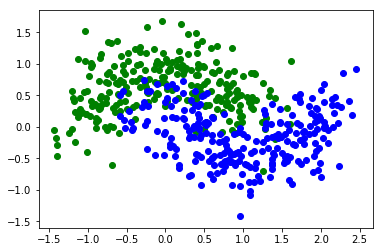

In [20]:
plt.scatter(X[:,0][y==0], X[:, 1][y==0], color='green')
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], color='blue')
plt.show()

In [8]:
# model with 500 trees, each with 100 samples 
bag_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                            n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [35]:
def plot_moons(X, y, axes):
    plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='green', marker='.', s=100)
    plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='blue', marker='.', s=100)
    plt.axis(axes)
    plt.xlabel(r'$X_1$', fontsize=18)
    plt.ylabel(r'$X_2$', fontsize=18)

green_blue_cmap = ListedColormap(['#008000', '#0000ff'])

def plot_decision_bounds(clf, axes, y_pred):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X = np.c_[x1.ravel(), x2.ravel()]
    
    y_pred = clf.predict(X).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, cmap=green_blue_cmap, alpha=0.4)

In [23]:
# train model with single tree
single_tree_clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
y_pred_single_tree = single_tree_clf.predict(X_test)

print('BaggingClassifier accuracy: {:.3f}'.format(bag_clf.score(X_test, y_test)))
print('Single DecisionTreeClassfier accuracy: {:.3f}'.format(single_tree_clf.score(X_test, y_test)))

BaggingClassifier accuracy: 0.880
Single DecisionTreeClassfier accuracy: 0.856


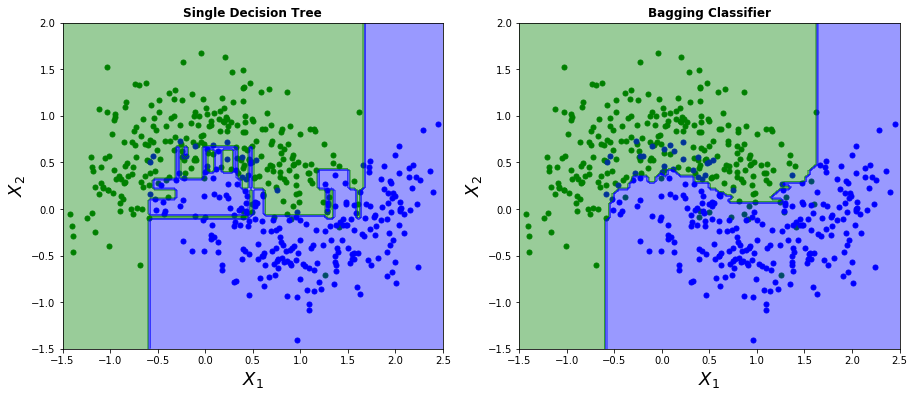

In [36]:
# plot both classifiers

axes=[-1.5, 2.5, -1.5, 2]

plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plot_moons(X, y, axes)
plot_decision_bounds(single_tree_clf, axes, y_pred_single_tree)
plt.title('Single Decision Tree', weight='bold')

plt.subplot(1,2,2)
plot_moons(X, y, axes)
plot_decision_bounds(bag_clf, axes, y_pred[:125])
plt.title('Bagging Classifier', weight='bold')

plt.show()

### Out-of-Bag Evaluation

* When `bootstrap=True`, on average 63% of the instances in training set are sampled, leaving 37% of the data out.
* This remaining data - **out-of-bag oob** - can be used as validation for the model, giving no need for additional cross-validation
* the `oob_score=True` parameter must be set 

In [37]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            bootstrap=True, n_jobs=-1, oob_score=True).fit(X_train, y_train)

print('BaggingClassifier oob_score: {:.3f}'.format(bag_clf.oob_score_))
print('BaggingClassifier accuracy score: {:.3f}'.format(bag_clf.score(X_test, y_test)))

BaggingClassifier oob_score: 0.885
BaggingClassifier accuracy score: 0.848


* Pretty much the same scores. Exactly what we wanted to prove.

### Feature Sampling

* As one can sample data instances one can also do it on features
* Each predictor has thus has different subset of features
* These are controlled by two hyperparameters: `max_features` and `bootstratp_features`
* These work equivalently as `max_samples` and `bootstrap`
* Such sampling may be usefuel with **images**
* **Random Patches method** - sampling both training instances and features
* **Random Subpaches method** - keeping all training instances but sampling features

## Ensemble of Decision Trees

* as we have carrid out our examples on `BaggingClassifier` with decsion trees, there is special `RandomForestClassifier` and `RandomForestRegressor` estimator classes that are practically Bagging Classifiers but optimized for decision trees
* `BaggingClassifiers` are still useful for estmators other than decision trees

## Boosting

* **hypothesis boosting** - ensemble method that combines set of weak learnins into a strong learner
* *general idea*: train each predeictor sequentially so that each trying to correct its predecessor
* two main methods:
    * **Adaptive Boosting**
    * **Gradient Boosting**

### AdaBoost

* Technique: New predictor focuses and corrects **underfitted** training instances.
* Thus new predictor focuses on hard cases. 
* The method updates the relative training instances weight values for each predictor
* Each instance weigth is initialized as $\frac{1}{m}$ where $m$ is th number of instances
* Gradually these weights are decreased for cases the model made an classification error. They wil get negative values 
* In sklearn there are `AdaBoostClassifier()` class for binary classification
* For multiclass one can specify `algorithm='SAMME'` or `algorithm='SAMME.R'` parameters in AdaBoostClassifier()

### Gradient Boosting

* sequentially adding predictors to the ensemble, each correcting its predecessor
* new predictor is fitted to the **residual errors** made by the previous predicotor
* this method works for classification and regression

In [73]:
# create some noisy data
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [74]:
X.min(), X.max(), y.min(), y.max()

(-0.4944778828763976,
 0.4868869366005173,
 -0.07017795621787389,
 0.759622208242618)

In [82]:
def plot_predictions(ensemble, X, y, axes):
    xs = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(reg.predict(xs.reshape(-1, 1)) for reg in ensemble)
    
    plt.plot(X[:,0], y, 'b.')
    plt.plot(xs, y_pred, 'r-')
    plt.axis(axes)

In [60]:
gb_reg = GradientBoostingRegressor(learning_rate=1, n_estimators=3, max_depth=2, 
                                   random_state=0).fit(X, y)

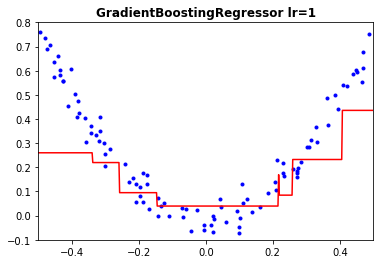

In [83]:
axes = [-0.5, 0.5, -0.1, 0.8]
plot_predictions([gb_reg], X, y, axes)
plt.title('GradientBoostingRegressor lr=1', weight='bold')
plt.show()

* hyperparameter `learning_rate` scales the contribution of each tree
* **shrinkage** - setting `learning_rate` low, such as 0.1 will need more trees yet yield better generalization 

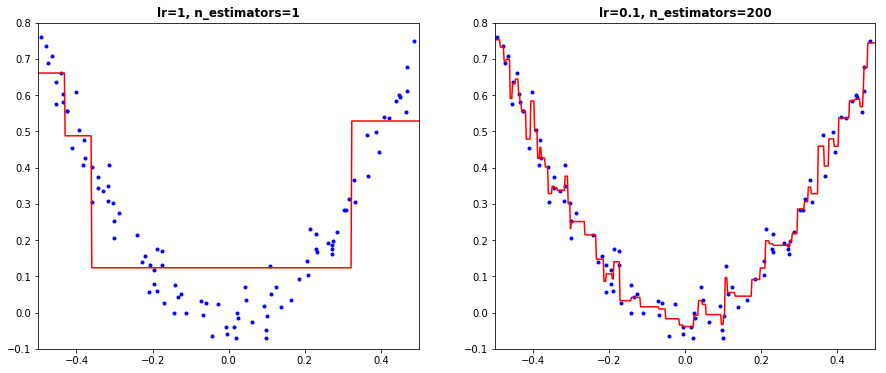

In [87]:
# model with high lr
gb_low_reg = GradientBoostingRegressor(learning_rate=1, n_estimators=1, max_depth=2,
                                        random_state=0).fit(X, y)
# model with low lr
gb_high_reg = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth=2,
                                        random_state=0).fit(X, y)

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.title('lr=1, n_estimators=1', weight='bold')
plot_predictions([gb_low_reg], X, y, axes)

plt.subplot(122)
plt.title('lr=0.1, n_estimators=200', weight='bold')
plot_predictions([gb_high_reg], X, y, axes)
plt.show()

* model in the left has too little trees while model in the right has too many

#### Optimal Number of Trees

* Keeping track of the validation error scores and picking the smalles one
* For this use `staged_predict()` method which returns iterator how many trees were used at each stage of the training (1, 2, 3 ...)

Let's train an ensemble of 120 trees and evaluate forest validation errors:

In [105]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gb_reg = GradientBoostingRegressor(n_estimators=120, max_depth=2).fit(X_train, y_train)

# capture the mean squred errors for estimators [1; 120]
val_errors = [mean_squared_error(y_val, y_pred) for y_pred in gb_reg.staged_predict(X_val)]

# capture the argment of the minimum error
best_n_estimators = np.argmin(val_errors)

# train the best model
best_gb_reg = GradientBoostingRegressor(n_estimators=best_n_estimators + 1, 
                                        max_depth=2, random_state=42).fit(X_train, y_train)

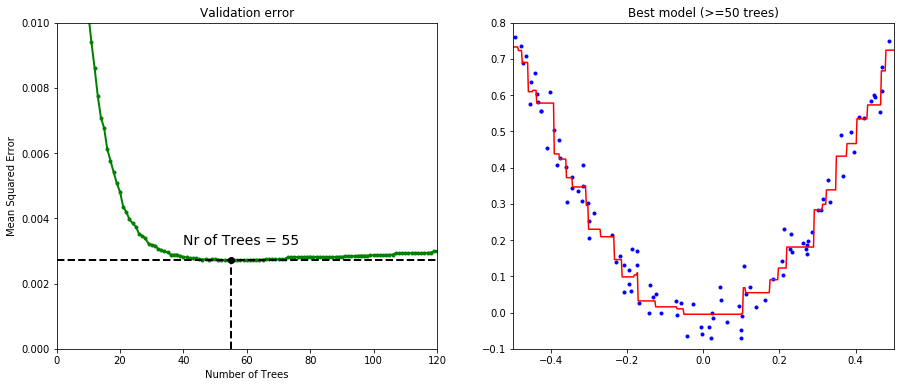

In [134]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(np.arange(1, 121, 1), val_errors, 'g.-', lw=2)
plt.axis([0, 120, 0, 0.01])
plt.axhline(y=np.min(val_errors), xmin=0, xmax=120, ls='--', c='k', lw=2)
plt.plot([np.argmin(val_errors), np.argmin(val_errors)], [0, np.min(val_errors)], 
         ls='--', c='k', lw=2)
plt.plot(best_n_estimators, np.min(val_errors), "ko")
plt.text(40, 0.0032, s='Nr of Trees = {}'.format(np.argmin(val_errors)), fontsize=14)
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.title('Validation error')

plt.subplot(122)
plot_predictions([best_gb_reg], X, y, axes)
plt.title('Best model (>=50 trees)')

plt.show()

* don't have to train all the trees but can use early stopping instead
* we can use parameter `warm_start=True` keeps previous tree info and allows incremental training
* stop the model when validation error hasn't dropped 5 iterations in a row

In [140]:
gb_reg = GradientBoostingRegressor(max_depth=2, random_state=0,
                                   warm_start=True)

min_val_error = np.inf
error_stall = 0
all_errors = []
for n_estimators in range(1, 121):
    gb_reg.n_estimators = n_estimators # init n_estimators for the model
    gb_reg.fit(X_train, y_train)
    y_pred = gb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    all_errors.append(val_error)
    if val_error < min_val_error:
        min_val_error = val_error
        error_stall = 0
    else:
        error_stall += 1
        if error_stall == 5:
            break # early stop

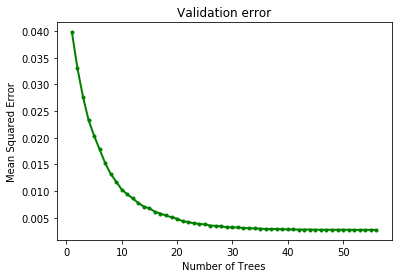

In [145]:
plt.plot(np.arange(1, len(all_errors) + 1 - 5, 1), all_errors[:-5], 'g.-', lw=2)
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.title('Validation error')
plt.show()

#### Stochastic Gradient Boosting

* by specifying hyperparamter `subsample=0.25` each tree is trained 1/4 of the training instances
* this trades higher bias for lower variance
* this speeds up training process considerably

# Exercises

## MNIST Exercise

* Load the MNIST data
* split it into a training set, a validation set, and a test set (e.g., use the first 40,000 instances for training, the next 10,000 for validation, and the last 10,000 for testing). 
* train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM. 
* Try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier. 
* Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?

In [150]:
# loading the dataset
mnist = datasets.fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

**MNIST dataset**:
* 70,000 images of handwritten digits
* 784 features (pixels)
* each feature respresents one pixel intensity from 0 (white) to 255 (black)
* Each image has $28\times28=784$ pixels

In [151]:
mnist.data.shape

(70000, 784)

In [160]:
# since the dataset is huge lets extract 45K instances
mnist_45k = mnist.data[:45000, :]
y_45k = mnist.target[:45000]

In [162]:
# split the data into training, validation and testing sets
X_train, X_testval, y_train, y_testval = train_test_split(mnist_45k, y_45k, test_size=20/45,
                                                    random_state=7, stratify=y_45k)

X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, stratify=y_testval,
                                                test_size=0.5, random_state=7)

In [163]:
X_train.shape, X_val.shape, X_test.shape

((25000, 784), (10000, 784), (10000, 784))

In [167]:
# train various classifiers
rf_clf = RandomForestClassifier(n_estimators=10, random_state=7, 
                                n_jobs=-1)
et_clf = ExtraTreesClassifier(n_estimators=10, random_state=7, n_jobs=-1)
svm_clf = LinearSVC(random_state=7)

classifiers = [rf_clf, et_clf, svm_clf]

for clf in classifiers:
    clf.fit(X_train, y_train)
    print('{} accuracy: {:.3f}'.format(clf.__class__.__name__,
                                       clf.score(X_val, y_val)))

RandomForestClassifier accuracy: 0.929
ExtraTreesClassifier accuracy: 0.936
LinearSVC accuracy: 0.869


/home/tonu_ilves/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [168]:
hard_ensemble_clf = VotingClassifier([
    ('rf_clf', rf_clf),
    ('et_clf', et_clf),
    ('svm_clf', svm_clf)
], voting='hard').fit(X_train, y_train)

print('Hard Voting Classifier accuracy: {:.3f}'.format(hard_ensemble_clf.score(X_val, y_val)))

/home/tonu_ilves/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Hard Voting Classifier accuracy: 0.936


In [170]:
soft_ensemble_clf = VotingClassifier([
    ('rf_clf', rf_clf),
    ('et_clf', et_clf)
], voting='soft').fit(X_train, y_train)

print('Soft Voting Classifier accuracy: {:.3f}'.format(soft_ensemble_clf.score(X_val, y_val)))

Soft Voting Classifier accuracy: 0.951


In [171]:
print('Soft Voting Classifier test accuracy: {:.3f}'.format(soft_ensemble_clf.score(X_test, y_test)))

Soft Voting Classifier test accuracy: 0.949
